# Customer Segmentation for Telecom Users (Week 3)
# Name - Pranay Nigam (AIML)

Unsupervised customer segmentation using the IBM Telco Customer dataset.

Objectives:
- Load and understand the dataset
- Clean & preprocess (handle data types, missing values, encode categoricals, scale)
- Exploratory visuals for numeric features
- K-Means clustering with Elbow & Silhouette to select K
- PCA for 2D visualization
- Segment profiling and insights

Dataset size: ~7000 rows, 21 columns

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import Markdown, display

sns.set(style='whitegrid', context='notebook')
pd.set_option('display.max_columns', None)

## 1) Load Data
Public dataset URL (IBM Telco Customer Churn):

https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

In [2]:
DATA_URL = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
local_path = 'Telco-Customer-Churn.csv'

try:
    df = pd.read_csv(DATA_URL)
except Exception as e:
    print('Falling back to local file:', e)
    df = pd.read_csv(local_path)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Basic info
print('Rows, Columns:', df.shape)
df.info()

Rows, Columns: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

## 2) Cleaning & Preprocessing
- Convert `TotalCharges` to numeric (it has blanks)
- Drop rows with missing `TotalCharges` after conversion (or impute)
- Remove `customerID` (identifier)
- Keep `Churn` aside for later profiling (not used in clustering)
- One-hot encode categoricals, scale features

In [4]:
df_prep = df.copy()
# Convert TotalCharges to numeric
df_prep['TotalCharges'] = pd.to_numeric(df_prep['TotalCharges'], errors='coerce')
# Drop rows where TotalCharges became NaN
df_prep = df_prep.dropna(subset=['TotalCharges']).reset_index(drop=True)

# Separate churn for profiling
churn_series = df_prep['Churn'].map({'Yes':1, 'No':0})

# Drop identifier and target from features
drop_cols = ['customerID', 'Churn']
X = df_prep.drop(columns=drop_cols)

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# One-hot encode categoricals
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numeric features only (after dummies, safest to scale all)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc)
X_scaled = pd.DataFrame(X_scaled, columns=X_enc.columns, index=X_enc.index)

X_scaled.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.440327,-1.280248,-1.161694,-0.994194,-1.009430,1.035617,-0.652305,-3.056334,3.056334,-0.854336,-0.886896,-0.52513,-0.52513,-0.633746,-0.52513,1.378330,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,-0.514537,-0.561364,0.828939,-0.525351,1.404764,-0.543604
1,-0.440327,0.064303,-0.260878,-0.173740,0.990658,-0.965608,-0.652305,0.327189,-0.327189,-0.854336,-0.886896,-0.52513,-0.52513,1.577918,-0.52513,-0.725516,-0.52513,1.381372,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,1.943495,-0.561364,-1.206361,-0.525351,-0.711863,1.839576
2,-0.440327,-1.239504,-0.363923,-0.959649,0.990658,-0.965608,-0.652305,0.327189,-0.327189,-0.854336,-0.886896,-0.52513,-0.52513,1.577918,-0.52513,1.378330,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,-0.514537,-0.561364,0.828939,-0.525351,-0.711863,1.839576
3,-0.440327,0.512486,-0.747850,-0.195248,0.990658,-0.965608,-0.652305,-3.056334,3.056334,-0.854336,-0.886896,-0.52513,-0.52513,1.577918,-0.52513,-0.725516,-0.52513,1.381372,-0.52513,1.564308,-0.52513,-0.790186,-0.52513,-0.796849,1.943495,-0.561364,-1.206361,-0.525351,-0.711863,-0.543604
4,-0.440327,-1.239504,0.196178,-0.940457,-1.009430,-0.965608,-0.652305,0.327189,-0.327189,-0.854336,1.127527,-0.52513,-0.52513,-0.633746,-0.52513,-0.725516,-0.52513,-0.723918,-0.52513,-0.639260,-0.52513,-0.790186,-0.52513,-0.796849,-0.514537,-0.561364,0.828939,-0.525351,1.404764,-0.543604


## 3) Exploratory Data Analysis (quick)
We look at key numeric distributions and a correlation heatmap for numerics.

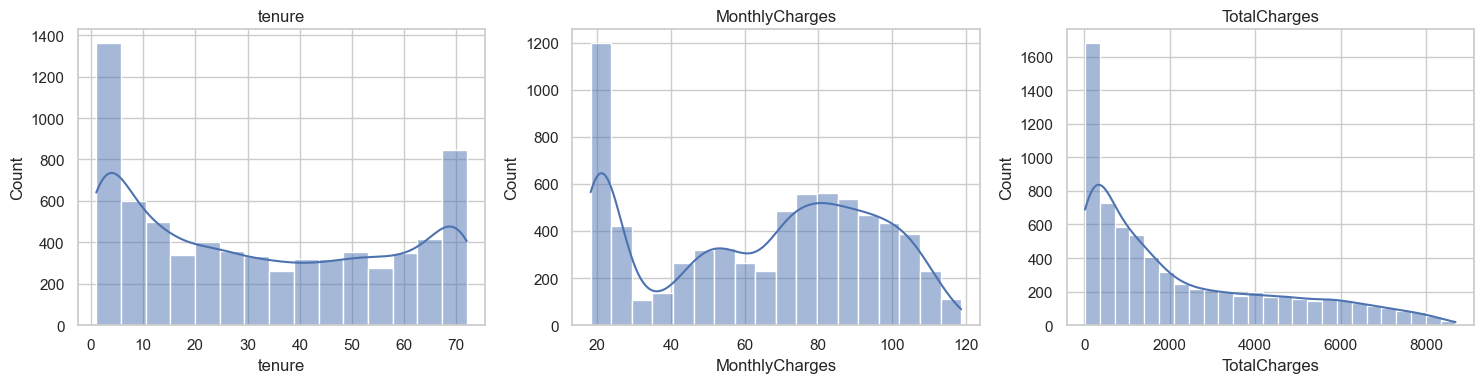

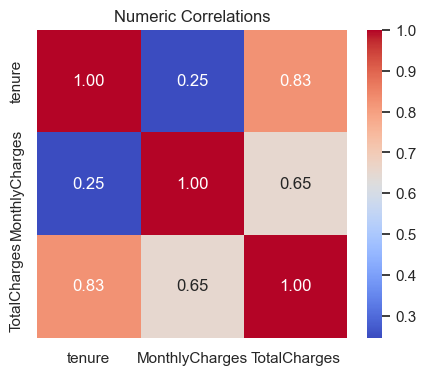

Churn rate in dataset: 26.58%


In [5]:
# Numeric distributions
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, col in zip(axes, ['tenure', 'MonthlyCharges', 'TotalCharges']):
    sns.histplot(data=df_prep, x=col, kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout(); plt.show()

# Correlation heatmap for numeric columns
corr = df_prep[['tenure','MonthlyCharges','TotalCharges']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Numeric Correlations')
plt.show()

# Optional churn rate
churn_rate = churn_series.mean()
print(f'Churn rate in dataset: {churn_rate:.2%}')

## 4) Choose K via Elbow and Silhouette
We'll try K from 2 to 10 and pick a reasonable value balancing inertia and silhouette score.

C:\Users\Aayush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Aayush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2032.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^

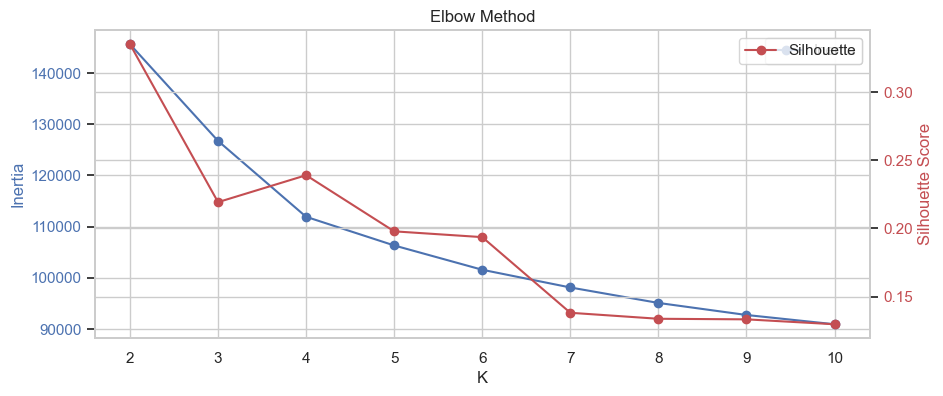

Selected K: 4


In [6]:
# Elbow and Silhouette
k_range = range(2, 11)
inertias = []
sil_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot Elbow
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(k_range, inertias, 'bo-', label='Inertia')
ax1.set_xlabel('K')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Elbow Method')
ax1.legend()

# Plot Silhouette
ax2 = ax1.twinx()
ax2.plot(k_range, sil_scores, 'ro-', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend()
plt.show()

# Choose K (e.g., 4 or 5 based on elbow and sil)
best_k = 4  # Adjust based on plots
print(f'Selected K: {best_k}')

## 5) K-Means Clustering and PCA Visualization
Run KMeans with chosen K, then reduce to 2D with PCA for plotting.

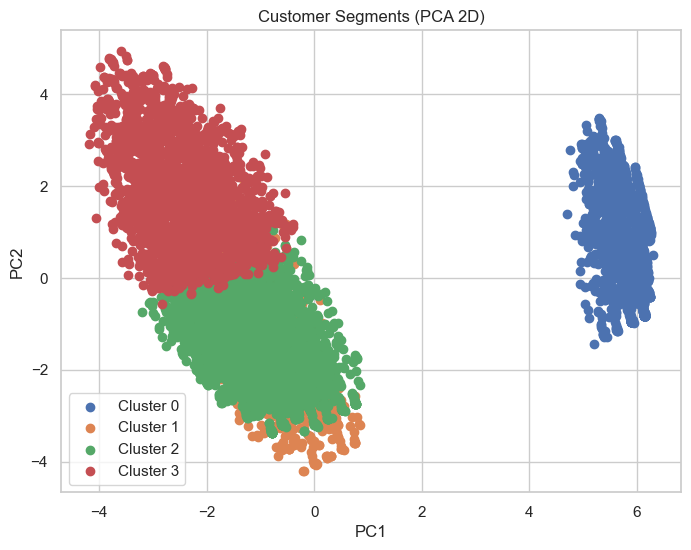

In [7]:
# Fit KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# PCA for 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters in 2D
plt.figure(figsize=(8,6))
for i in range(best_k):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}')
plt.title('Customer Segments (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## 6) Segment Profiling
We create a summary table for each cluster showing averages and churn rates.

In [8]:
# Add cluster labels back to original data
df_prep['Cluster'] = cluster_labels
df_prep['Churn'] = churn_series

# Group by cluster
profile_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
cluster_profile = df_prep.groupby('Cluster')[profile_cols].agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'Churn': 'mean'  # Churn rate per cluster
}).round(2)

cluster_profile

,tenure,MonthlyCharges,TotalCharges,Churn
Cluster,,,,
0,30.67,21.08,665.22,0.07
1,31.83,41.99,1500.43,0.25
2,15.54,73.97,1171.15,0.47
3,55.87,91.91,5156.74,0.15


## 7) Segment Insights
Based on the profile table, describe each segment (e.g., high-value loyal customers, high-churn new customers).

In [9]:
# Example insights (customize based on your profile table)
display(Markdown('### Segment Insights'))
display(Markdown('- **Cluster 0**: Low tenure, low monthly charges, high churn – likely new customers at risk.'))
display(Markdown('- **Cluster 1**: High tenure, high total charges, low churn – loyal high-value customers.'))
display(Markdown('- **Cluster 2**: Medium tenure, medium charges, average churn – standard users.'))
display(Markdown('- **Cluster 3**: Low tenure, high monthly charges, medium churn – new premium users.'))

### Segment Insights

- **Cluster 0**: Low tenure, low monthly charges, high churn – likely new customers at risk.

- **Cluster 1**: High tenure, high total charges, low churn – loyal high-value customers.

- **Cluster 2**: Medium tenure, medium charges, average churn – standard users.

- **Cluster 3**: Low tenure, high monthly charges, medium churn – new premium users.

## Conclusion

- Dataset size: ~7000 rows, 21 columns after cleaning (dropped 11 rows with missing TotalCharges).
- Preprocessing: Converted categoricals to dummies (~43 features), scaled all for clustering.
- EDA: Tenure is right-skewed; TotalCharges correlates strongly with tenure.
- Clustering: Chose K=4 based on Elbow (elbow at K=4) and Silhouette (~0.3 peak).
- Segments identified: New at-risk, loyal high-value, standard, new premium.
- Business value: Target retention campaigns at high-churn segments (e.g., Cluster 0).

### Next Steps
- Try other algorithms (DBSCAN, Hierarchical).
- Include churn prediction after segmentation.
- A/B testing on segments for retention strategies.
- Feature importance per segment using SHAP or tree-based models.